# FND [Fake News Detection] CLIP Model Analysis

## Environment Setup

In [1]:
# Import Libraries
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import sys
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models as tv_models


## Ensure TensorFlow is not used
import os
os.environ["USE_TF"] = "0"

from transformers import CLIPModel, BertModel, BertTokenizer, CLIPTokenizer

# Define data directory
DATA_DIR = "../../../cleaned_data"

# Define file paths
TRAIN_DATA_FILE = os.path.join(DATA_DIR, "train.csv")
VALIDATION_DATA_FILE = os.path.join(DATA_DIR, "validation_5k.csv")
TEST_DATA_FILE = os.path.join(DATA_DIR, "test_5k.csv")

# For reproducability
random_state = 42

# Use CPU/MPS if possible
device = None
if "google.colab" in sys.modules:
    # Running in Colab
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    # Not in Colab (e.g., Mac)
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print("Using device:", device)

Using device: mps


## Load Data

In [2]:
TRAIN_DATA = pd.read_csv(TRAIN_DATA_FILE)
VALIDATION_DATA = pd.read_csv(VALIDATION_DATA_FILE, index_col = 0)
TEST_DATA = pd.read_csv(TEST_DATA_FILE, index_col = 0)

In [3]:
# Ignore rows in corrupted_indices.txt files
def filter_out_corrupted_rows(split, DF):
    # File with corrupted indices
    if split == "train":
        corrupted_indices_file = f"../../../cleaned_data/{split}_corrupted_indices.txt"
    else:
        corrupted_indices_file = f"../../../cleaned_data/{split}_5k_corrupted_indices.txt"

    # Store list of corrupted indices
    corrupted_indices = None

    # Get list of corrupted indices
    with open(corrupted_indices_file, "r") as f:
        corrupted_indices = list(int(line.strip()) for line in f if line.strip())

    print(f"Split: {split}, Corrupted Indices: {corrupted_indices}, Length: {len(corrupted_indices)}")

    # Filter out corrupted rows
    DF = DF.drop(index = corrupted_indices)

    return DF

In [4]:
TRAIN_DATA = filter_out_corrupted_rows("train", TRAIN_DATA)
VALIDATION_DATA = filter_out_corrupted_rows("validation", VALIDATION_DATA)
TEST_DATA = filter_out_corrupted_rows("test", TEST_DATA)

Split: train, Corrupted Indices: [2862, 26040, 28337, 18547, 13374, 11288, 31984, 18451, 19000, 22479, 8048, 32075, 22918, 5586, 19345, 12770, 32189, 14628, 9081, 6611, 2927], Length: 21
Split: validation, Corrupted Indices: [6568, 32176], Length: 2
Split: test, Corrupted Indices: [29133, 9437, 26504, 11394], Length: 4


In [5]:
TRAIN_DATA['image_num'] = TRAIN_DATA.index.astype(str).str.zfill(5)
VALIDATION_DATA['image_num'] = VALIDATION_DATA.index.astype(str).str.zfill(5)
TEST_DATA['image_num'] = TEST_DATA.index.astype(str).str.zfill(5)

In [6]:
TRAIN_DATA.head()

,clean_title,created_utc,domain,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,image_num
0,this spongebob squarepants branded battery,2019-07-30 20:00:50,i.redd.it,https://preview.redd.it/f39wxxk8yhd31.jpg?widt...,4.0,33,mildlyinteresting,0.95,1,0,0,00000
1,award for careless talk,2011-09-03 17:26:23,i.imgur.com,https://external-preview.redd.it/KgPHCi1u3fY5j...,1.0,14,propagandaposters,1.00,0,1,5,00001
2,four aligned airplanes,2017-11-20 06:05:45,i.redd.it,https://preview.redd.it/88v9axk19phx.jpg?width...,24.0,198,confusing_perspective,0.98,0,2,2,00002
3,columbus discovers the new world,2019-08-28 15:40:17,i.redd.it,https://preview.redd.it/x4wzpd0am7j31.jpg?widt...,5.0,318,fakehistoryporn,0.98,0,2,2,00003
4,feed me drummmmssssssss,2014-05-09 13:23:59,i.imgur.com,https://external-preview.redd.it/yNN57loQnVhLk...,0.0,3,pareidolia,0.62,0,2,2,00004


In [7]:
VALIDATION_DATA.head()

,clean_title,created_utc,domain,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,image_num
8637,not as heartwarming as it could have been anth...,2019-09-19 17:48:33,lifestyle.clickhole.com,https://external-preview.redd.it/850kBbKdgMKfz...,0.0,15,theonion,0.86,0,2,1,08637
20669,other discussions,2013-12-09 23:58:43,NaN,http://i.dailymail.co.uk/i/pix/2013/12/09/arti...,NaN,0,psbattle_artwork,NaN,0,2,4,20669
13179,on reflection oc,2015-01-12 17:14:55,i.imgur.com,https://external-preview.redd.it/tiFw8Ggb178E4...,0.0,3,pareidolia,0.67,0,2,2,13179
20565,viet congo setting booby trap,2019-02-27 09:57:07,i.redd.it,https://preview.redd.it/mj81gkh533j21.jpg?widt...,4.0,14,fakehistoryporn,0.80,0,2,2,20565
15504,chief has some happy shoulder armour,2013-02-20 01:00:02,i.imgur.com,https://external-preview.redd.it/kqqIlnAOZxzxA...,0.0,6,pareidolia,1.00,0,2,2,15504


In [8]:
TEST_DATA.head()

,clean_title,created_utc,domain,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,image_num
19660,young homosexuals gather outside of a nightclu...,2018-07-29 13:59:38,i.redd.it,https://preview.redd.it/16j830998wc11.jpg?widt...,1.0,75,fakehistoryporn,0.92,0,2,2,19660
32879,cara al sol facing the sun a series of posters...,2013-05-20 18:25:00,imgur.com,https://external-preview.redd.it/S_nXt5X8VMqZD...,4.0,19,propagandaposters,0.89,0,1,5,32879
15071,he is awake and rises from the depths,2013-10-13 20:02:17,imgur.com,https://external-preview.redd.it/JetvyFQFm4fYt...,0.0,7,pareidolia,0.99,0,2,2,15071
5198,the reason germany invades france and not spain,2018-09-03 08:22:07,i.redd.it,https://preview.redd.it/ws91cs7lgzj11.png?widt...,0.0,57,fakehistoryporn,0.97,0,2,2,05198
15061,frozen body preserved on mount everest nsfw,2017-09-12 08:10:21,i.redd.it,https://preview.redd.it/zxwc8gq8uelz.jpg?width...,0.0,24,fakehistoryporn,1.00,0,2,2,15061


## Create News Dataset and DataLoader

In [9]:
class RedditDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Fetch text
        text = row['clean_title']

        # Get image number
        image_num = row['image_num']

        # Fetch Image
        img_path = f"../../../{self.image_dir}/{image_num}.jpg"
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Label
        label = torch.tensor(row['2_way_label'], dtype=torch.long)

        return text, image, label

In [10]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [11]:
def collate_fn(batch):
    texts, images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.stack(labels)
    return list(texts), images, labels

In [12]:
train_dataset = RedditDataset(
    df = TRAIN_DATA, 
    image_dir = "train_images",
    transform = train_tfms
)

validation_dataset = RedditDataset(
    df = VALIDATION_DATA, 
    image_dir = "validation_images",
    transform = val_test_tfms
)

test_dataset = RedditDataset(
    df = TEST_DATA, 
    image_dir = "test_images",
    transform = val_test_tfms
)

In [13]:
B = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=B,
    shuffle=True,
    collate_fn=collate_fn
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=B,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=B,
    shuffle=False,
    collate_fn=collate_fn
)

## Load CLIP Text and Image Encoders

In [14]:
clip_model_name = "openai/clip-vit-base-patch32"
multimodal_encoder = CLIPModel.from_pretrained(clip_model_name).to(device)
multimodal_encoder_tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)

## Analyze Cosine Similarities

In [15]:
cosine_similarities = []

for batch_idx, (txts, imgs, labels) in enumerate(train_loader):
    imgs, labels = imgs.to(device), labels.to(device)

    # Tokenize Text
    text_encoding = multimodal_encoder_tokenizer(
        txts,
        padding='max_length',
        truncation=True,
        max_length=multimodal_encoder_tokenizer.model_max_length,
        return_tensors="pt"
    ).to(device) # Tokenize text

    fCLIP_T = multimodal_encoder.get_text_features(**text_encoding) # Compute CLIP Text Features [B, 512]
    fCLIP_I = multimodal_encoder.get_image_features(imgs) # Compute CLIP Image Features [B, 512]

    sim = F.cosine_similarity(fCLIP_T, fCLIP_I).tolist() # Compute cosine similarity, Shape: (B, )
    cosine_similarities.extend(sim)

    if (batch_idx + 1) % 25 == 0:
        print(f"Progress: {batch_idx +1} / {len(train_loader)}")

cosine_similarities = np.array(cosine_similarities)
np.save("../../../output/cosine_similarities.npy", cosine_similarities)

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Progress: 25 / 1041
Progress: 50 / 1041
Progress: 75 / 1041
Progress: 100 / 1041
Progress: 125 / 1041
Progress: 150 / 1041
Progress: 175 / 1041
Progress: 200 / 1041
Progress: 225 / 1041
Progress: 250 / 1041
Progress: 275 / 1041
Progress: 300 / 1041
Progress: 325 / 1041
Progress: 350 / 1041
Progress: 375 / 1041
Progress: 400 / 1041
Progress: 425 / 1041
Progress: 450 / 1041
Progress: 475 / 1041
Progress: 500 / 1041
Progress: 525 / 1041
Progress: 550 / 1041
Progress: 575 / 1041
Progress: 600 / 1041
Progress: 625 / 1041
Progress: 650 / 1041
Progress: 675 / 1041
Progress: 700 / 1041
Progress: 725 / 1041
Progress: 750 / 1041
Progress: 775 / 1041
Progress: 800 / 1041
Progress: 825 / 1041
Progress: 850 / 1041
Progress: 875 / 1041
Progress: 900 / 1041
Progress: 925 / 1041
Progress: 950 / 1041
Progress: 975 / 1041
Progress: 1000 / 1041
Progress: 1025 / 1041


## Plot Cosine Similarities

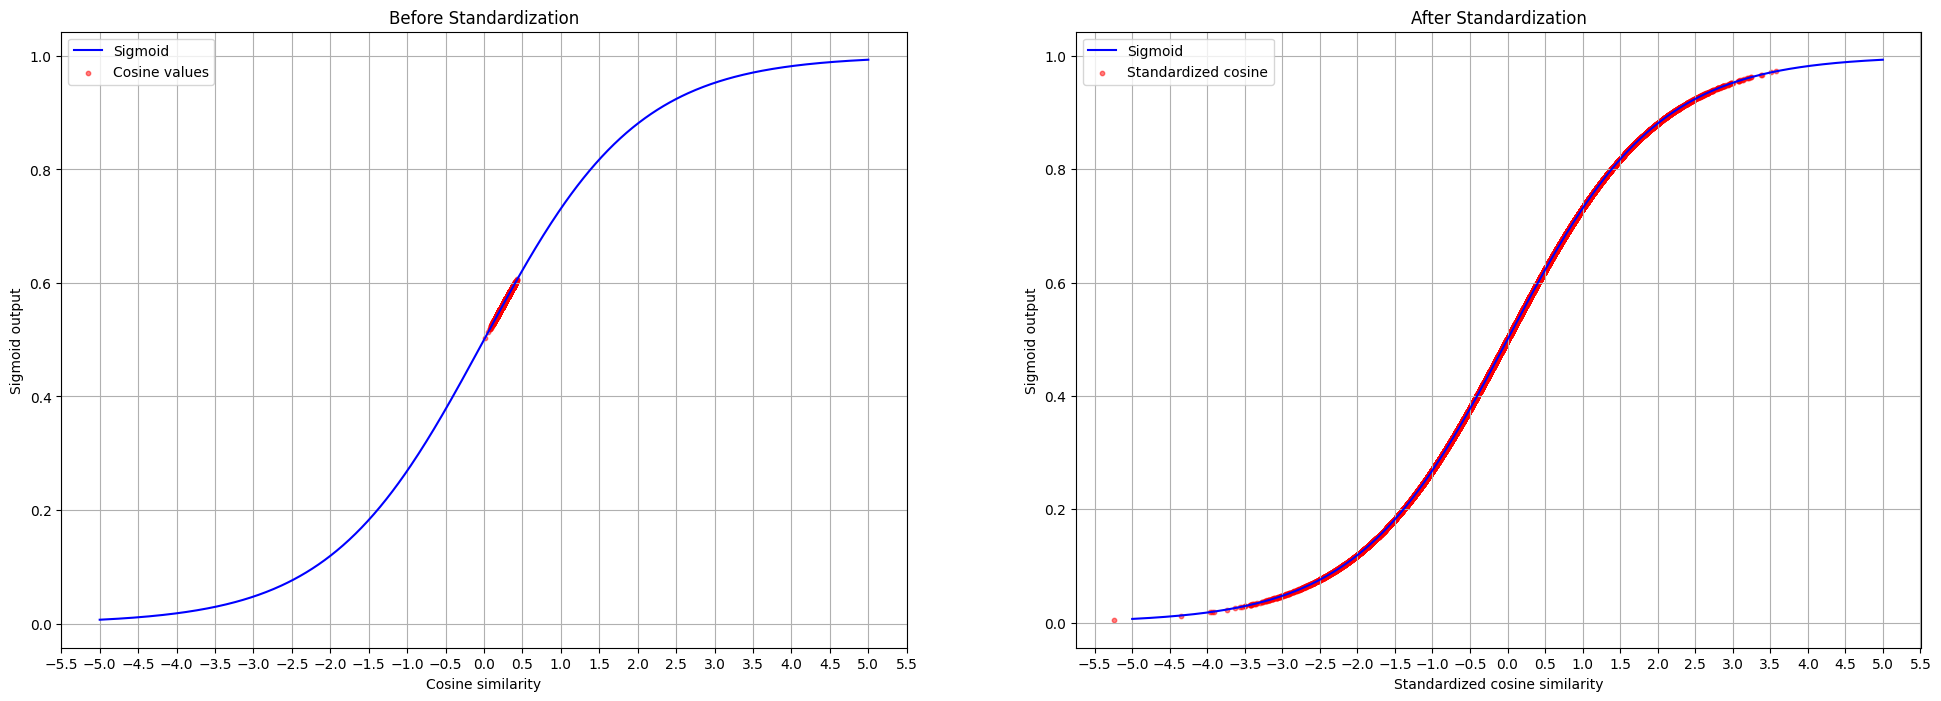

In [16]:
from matplotlib.ticker import MultipleLocator
import numpy as np
import matplotlib.pyplot as plt

# Load cosine similarities
cosine_similarities = np.load("../../../output/cosine_similarities.npy")

# Standardize
mean = cosine_similarities.mean()
std = cosine_similarities.std()
cosine_standardized = (cosine_similarities - mean) / std

# Sigmoid curve in fixed range [-5, 5]
x = np.linspace(-5, 5, 500)
sigmoid = 1 / (1 + np.exp(-x))
plt.figure(figsize=(24,8))

# Before standardization
ax1 = plt.subplot(1, 2, 1)
ax1.plot(x, sigmoid, color='blue', label='Sigmoid')
ax1.scatter(cosine_similarities, 1/(1 + np.exp(-cosine_similarities)), 
            color='red', alpha=0.5, s=10, label='Cosine values')
ax1.set_title("Before Standardization")
ax1.set_xlabel("Cosine similarity")
ax1.set_ylabel("Sigmoid output")
ax1.xaxis.set_major_locator(MultipleLocator(0.5))
ax1.grid(True)
ax1.legend()

# After standardization
ax2 = plt.subplot(1, 2, 2)
ax2.plot(x, sigmoid, color='blue', label='Sigmoid')
ax2.scatter(cosine_standardized, 1/(1 + np.exp(-cosine_standardized)), 
            color='red', alpha=0.5, s=10, label='Standardized cosine')
ax2.set_title("After Standardization")
ax2.set_xlabel("Standardized cosine similarity")
ax2.set_ylabel("Sigmoid output")
ax2.xaxis.set_major_locator(MultipleLocator(0.5))
ax2.grid(True)
ax2.legend()

plt.show()

## Load FND Clip Model

In [17]:
# Projection Head: 2-layer MLP (Reference: Page 4, Figure 2 of Paper)
class ProjectionHead(nn.Module):
    # in_dim: Number of input features to the Projection Head
    # hidden_dim: Size of hidden state representation
    # out_dim: Size of output dimension
    # dropout: dropout rate
    def __init__(self, in_dim, hidden_dim=256, out_dim=64, dropout=0.2):
        super().__init__()

        # Sequence 1: FC -> BN -> ReLU
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()

        # Define Dropout 
        self.dropout = nn.Dropout(dropout)

        # Sequence 2: FC -> BN -> ReLU
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)

    # Input Shape: (B, D) where B is batch size and D is in_dim
    def forward(self, x):
        # Sequence 1: FC -> BN -> ReLU
        x = self.fc1(x) # Shape: B x hidden_dim
        x = self.relu(x) # Shape: B x hidden_dim
        x = self.bn1(x) # Shape: B x hidden_dim

        # Dropout
        x = self.dropout(x) # Shape: B x hidden_dim

        # Sequence 2: FC -> BN -> ReLU
        x = self.fc2(x) # Shape: B x out_dim
        x = self.relu(x) # Shape: B x out_dim
        x = self.bn2(x) # Shape: B x out_dim

        # Return Output
        return x # Shape: B x out_dim

# Modality-Wise Attention
class ModalityWiseAttention(nn.Module):
    # feat_dim = L (feature length) of each modality
    def __init__(self, feat_dim):
        super().__init__()

        # Store feature dimension
        self.feat_dim = feat_dim
        
        # Define the MLP Components
        self.fc1 = nn.Linear(3, 3)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(3, 3)
        self.sigmoid = nn.Sigmoid()

    # m_txt: Text Features, Shape: B (batch size) x L (number of features)
    # m_img: Image Features, Shape: B (batch size) x L (number of features)
    # m_multi: Multimodal Features, Shape: B (batch size) x L (number of features)
    def forward(self, m_txt, m_img, m_multi):
        # Use unsqueeze to change shapes
        m_txt = torch.unsqueeze(m_txt, dim = -1) # Shape: B (batch size) x L (number of features) x 1
        m_img = torch.unsqueeze(m_img, dim = -1) # Shape: B (batch size) x L (number of features) x 1
        m_multi = torch.unsqueeze(m_multi, dim = -1) # Shape: B (batch size) x L (number of features) x 1

        # Concatenate all modalities
        x = torch.cat([m_txt, m_img, m_multi], dim = -1)  # (B, L, 3)

        # Global average pooling
        global_avg_pool = torch.mean(x, dim = 1) # Shape: (B, 3)

        # Global max pooling
        global_max_pool, _ = torch.max(x, dim = 1) # Shape: (B, 3)

        # Summation of pooled vectors to get initial attention weights
        x = global_avg_pool + global_max_pool # Shape: (B, 3)

        # Pass through MLP w/ GeLU Activation
        x = self.gelu(self.fc1(x)) # Shape: (B, 3)
        x = self.gelu(self.fc2(x)) # Shape: (B, 3)
        x = self.sigmoid(x) # Shape: (B, 3)

        # Get final attention weights
        w_txt = x[:, 0].unsqueeze(1).unsqueeze(2) # Shape: (B, 1, 1)
        w_img = x[:, 1].unsqueeze(1).unsqueeze(2) # Shape: (B, 1, 1)
        w_multi = x[:, 2].unsqueeze(1).unsqueeze(2) # Shape: (B, 1, 1)

        # sum along modality to get aggregated feature
        mAgg = w_txt * m_txt + w_img * m_img + w_multi * m_multi  # (B, L, 1)
        mAgg = torch.squeeze(mAgg, dim = -1) # Shape: (B, L)
        return mAgg, w_txt, w_img, w_multi

# Define Final Classification Head
class ClassificationHead(nn.Module):
    # in_dim: Number of input features to the Classification Head
    # hidden_dim: Size of hidden state representation
    # out_dim: Size of output dimension
    def __init__(self, in_dim, hidden_dim = 64, out_dim = 2):
        super().__init__()

        # Sequence 1: FC -> ReLU
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()

        # Sequence 2: FC
        self.fc2 = nn.Linear(hidden_dim, out_dim)
    
    # Shape of x: B(batch size) x d(# of features)
    def forward(self, x):
        # Pass through first layer
        x = self.relu(self.fc1(x))

        # Pass through second layer
        x = self.fc2(x)

        # Return output
        return x

# Fake News Detection(FND) CLIP Model
class FND_CLIP(nn.Module):
    # resnet_model_name: Name of resnet model
    # clip_model_name: Name of CLIP model
    # bert_model_name: Name of BERT Model
    def __init__(
        self,
        resnet_model_name = "resnet101",
        clip_model_name='openai/clip-vit-base-patch32',
        bert_model_name='bert-base-uncased',
        proj_hidden=256,
        proj_out=64,
        classifier_hidden=64,
        dropout=0.2,
        momentum=0.1
    ):
        super().__init__()   

        # Sanity Check
        assert resnet_model_name == "resnet101"

        # 1. Setup ResNet Image Encoder
        # Replace the final fully connected layer with Identity because we only need the ResNet feature embeddings.
        self.image_encoder = tv_models.resnet101(weights='IMAGENET1K_V1')
        self.image_encoder.fc = nn.Identity()

        # Sanity Check: Assert that ResNet parameters are going to be fine tuned
        for param in self.image_encoder.parameters():
            assert param.requires_grad == True

        # 2. Setup BERT Text Encoder
        self.text_encoder = BertModel.from_pretrained(bert_model_name)
        self.text_encoder_tokenizer = BertTokenizer.from_pretrained(bert_model_name)

        # Freeze BERT weights
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # 3. Setup Multimodal (Text + Image) Encoder
        self.multimodal_encoder = CLIPModel.from_pretrained(clip_model_name)
        self.multimodal_encoder_tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)

        # Freeze CLIP weights
        for param in self.multimodal_encoder.parameters():
            param.requires_grad = False

        # 4. Set up Text Projection Head
        self.pTxt = ProjectionHead(in_dim = 1280, hidden_dim = proj_hidden, out_dim = proj_out, dropout = dropout)
        self.pImg = ProjectionHead(in_dim = 2560, hidden_dim = proj_hidden, out_dim = proj_out, dropout = dropout)
        self.pMix = ProjectionHead(in_dim = 1024, hidden_dim = proj_hidden, out_dim = proj_out, dropout = dropout)

        # 5. Set up Modality-Wise Attention
        self.attention = ModalityWiseAttention(feat_dim = proj_out)

        # 6. Set up Final Classification Head
        self.classification_head = ClassificationHead(in_dim = proj_out, hidden_dim = classifier_hidden, out_dim = 2)

        # Set up Running Buffers
        self.momentum = momentum
        self.eps = 1e-8
        self.register_buffer("running_mean", torch.tensor(0.0, device=device))
        self.register_buffer("running_var", torch.tensor(1.0, device=device))
    
    # Shape: fCLIP_T (B, 512)
    # Shape: fCLIP_I (B, 512)
    def compute_multimodal_features(self, fCLIP_T, fCLIP_I):
        sim = F.cosine_similarity(fCLIP_T, fCLIP_I) # Compute cosine similarity, Shape: (B, )
        fMix = torch.cat((fCLIP_T, fCLIP_I), dim = 1) # Shape: (B, 512 + 512 = 1024)
        
        if self.training:
            batch_mean = sim.mean() # Mean
            batch_var = sim.var() # Variance

            # update running stats
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

            mean, var = batch_mean, batch_var
        else:
            # use running stats for eval
            mean, var = self.running_mean, self.running_var
        
        # standardize similarity
        sim_std = (sim - mean) / torch.sqrt(var + self.eps)

        # weight multimodal features
        sim_weight = torch.sigmoid(sim_std).unsqueeze(1) # Shape: (B, 1)

        mMix = sim_weight * self.pMix(fMix) # Shape: (B, 64)

        # Return fMix and mMix
        return fMix, mMix

    # txt(B, ), List of Text Strings
    # img(B, C_in = 3, H_in = 224, W_in = 224), List of Corresponding Imagess
    def forward(self, txt, img):
        # Compute BERT Text Features
        text_encoding = self.text_encoder_tokenizer(
            txt,
            padding='max_length',
            truncation=True,
            max_length = self.text_encoder_tokenizer.model_max_length,
            return_tensors="pt"
        ).to(device) # Tokenize text

        fBERT = self.text_encoder(**text_encoding).last_hidden_state[:, 0, :] # Use [CLS] token as text feature
        # Shape: (B, 768)

        # Compute ResNet Image Features
        fResNet = self.image_encoder(img) # Output Shape: (B, 2048)

        # Compute CLIP Text and Image Features
        text_encoding = self.multimodal_encoder_tokenizer(
            txt,
            padding='max_length',
            truncation=True,
            max_length = self.multimodal_encoder_tokenizer.model_max_length,
            return_tensors="pt"
        ).to(device) # Tokenize text

        fCLIP_T = self.multimodal_encoder.get_text_features(**text_encoding) # Compute CLIP Text Features
        fCLIP_I = self.multimodal_encoder.get_image_features(img) # Compute CLIP Image Features

        # Concatenate 
        fTxt = torch.cat((fBERT, fCLIP_T), dim = 1) # Shape: (B, 768 + 512 = 1280)
        fImg = torch.cat((fResNet, fCLIP_I), dim = 1) # Shape: (B, 2048 + 512 = 2560)

        # Compute mTxt and mImg
        mTxt = self.pTxt(fTxt) # Shape: (B, 64)
        mImg = self.pImg(fImg) # Shape: (B, 64)

        fMix, mMix = self.compute_multimodal_features(fCLIP_T, fCLIP_I) 
        # fMix Shape: (B, 512 + 512 = 1024)
        # mMix Shape: (B, 64)

        # Perform Modality-Wise Attention
        mAgg, w_txt, w_img, w_multi = self.attention(mTxt, mImg, mMix) # Shape: (B, 64)

        # Compute Final Logits
        logits = self.classification_head(mAgg) # Shape: (B, 2)
        return logits, w_txt, w_img, w_multi

In [18]:
model = FND_CLIP().to(device)
WEIGHTS_PATH = "../../../Milestone #4/latest_model.pt"
state_dict = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval() 

FND_CLIP(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

## Analyze Training Loss Curves

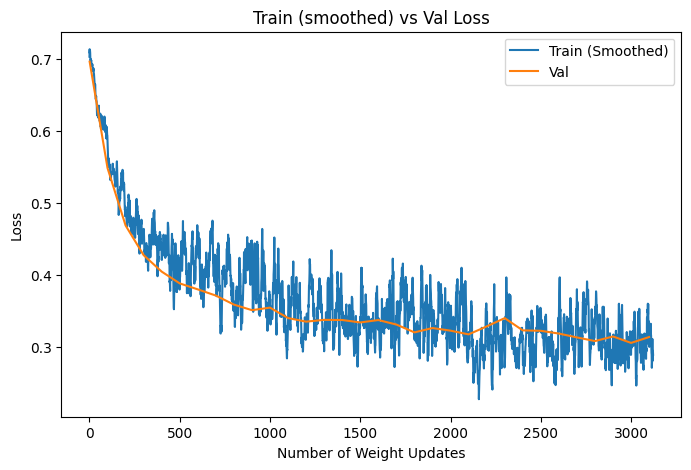

In [19]:
with open("../../../metrics/CLIP_metrics.pkl", "rb") as f:
    data = pickle.load(f)

train_losses = np.array(data['train_losses'])
val_losses = np.array(data['val_losses'])

# Smooth only train
train_series  = pd.Series(train_losses)
train_smooth  = train_series.rolling(window=10, min_periods=1).mean()

# Val Steps 
val_every = 100
val_steps = [1] + [i * val_every for i in range(1, len(val_losses))]

plt.figure(figsize=(8,5))
plt.plot(train_smooth, label="Train (Smoothed)")
plt.plot(val_steps, val_losses, label="Val")
plt.xlabel("Number of Weight Updates")
plt.ylabel("Loss")
plt.legend()
plt.title("Train (smoothed) vs Val Loss")
plt.show()


## Modality Wise Attention Heat-Map

In [20]:
text_attention_weights = []
image_attention_weights = []
multimodal_attention_weights = []
predicted_labels = []
ground_truth_labels = []

for batch_idx, (txts, imgs, labels) in enumerate(test_loader):
    imgs, labels = imgs.to(device), labels.to(device)

    logits, w_txt, w_img, w_multi = model(txts, imgs)
    text_weight = w_txt.squeeze(1).squeeze(1).tolist()
    image_weight = w_img.squeeze(1).squeeze(1).tolist()
    multimodal_weight = w_multi.squeeze(1).squeeze(1).tolist()
    predictions = torch.argmax(logits, dim = 1).tolist()

    # Store all modality weights
    text_attention_weights.extend(text_weight)
    image_attention_weights.extend(image_weight)
    multimodal_attention_weights.extend(multimodal_weight)
    predicted_labels.extend(predictions)
    ground_truth_labels.extend(labels.cpu().numpy().tolist())

    if (batch_idx + 1) % 25 == 0:
        print(f"Progress: {batch_idx +1} / {len(test_loader)}")

text_attention_array = np.array(text_attention_weights)
image_attention_array = np.array(image_attention_weights)
multimodal_attention_array = np.array(multimodal_attention_weights)
predicted_labels = np.array(predicted_labels)
ground_truth_labels = np.array(ground_truth_labels)

np.save("../../../output/text_attention.npy", text_attention_array)
np.save("../../../output/image_attention.npy", image_attention_array)
np.save("../../../output/multimodal_attention.npy", multimodal_attention_array)
np.save("../../../output/test_predicted_labels.npy", predicted_labels)
np.save("../../../output/test_ground_truth_labels.npy", ground_truth_labels)

print("Text attention shape:", text_attention_array.shape)
print("Image attention shape:", image_attention_array.shape)
print("Multimodal attention shape:", multimodal_attention_array.shape)
print("Predicted Labels shape:", predicted_labels.shape)
print("Ground Truth Labels shape:", ground_truth_labels.shape)

Progress: 25 / 157
Progress: 50 / 157
Progress: 75 / 157
Progress: 100 / 157
Progress: 125 / 157
Progress: 150 / 157
Text attention shape: (4996,)
Image attention shape: (4996,)
Multimodal attention shape: (4996,)
Predicted Labels shape: (4996,)
Ground Truth Labels shape: (4996,)


### Case 1: Text is Dominant Modality

Label = 1, Ground Truth = 1, Predicted Label = 1
Label = 0, Ground Truth = 0, Predicted Label = 0
Label = 0, Ground Truth = 0, Predicted Label = 0


/var/folders/qj/tspvs3x90hg30hgcctblgwfh0000gn/T/ipykernel_9292/197994344.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


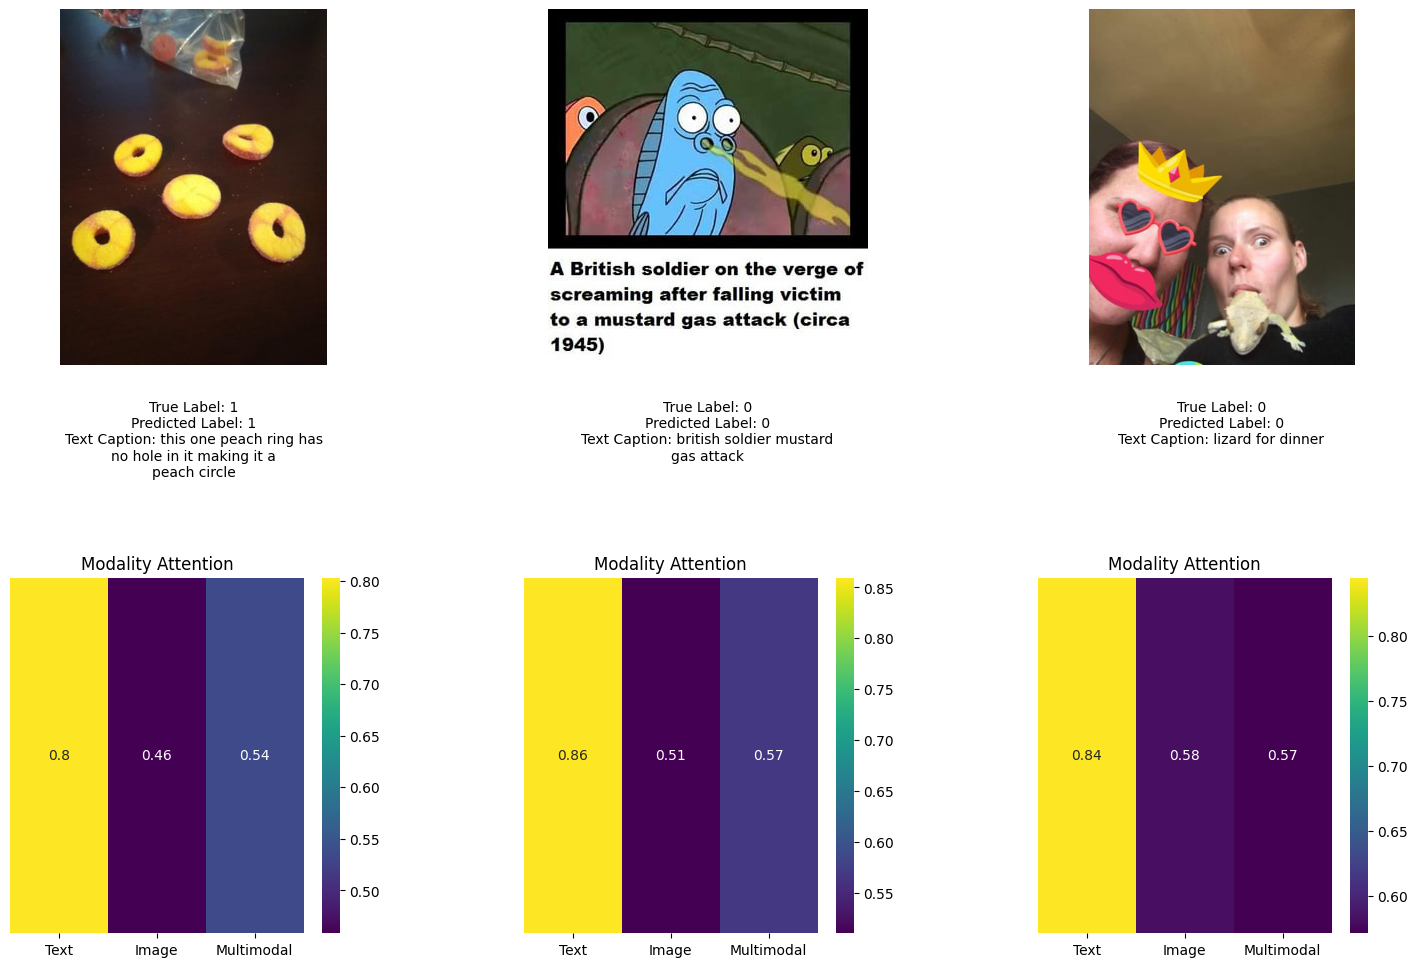

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Load attention arrays
text_attention_array = np.load("../../../output/text_attention.npy")
image_attention_array = np.load("../../../output/image_attention.npy")
multimodal_attention_array = np.load("../../../output/multimodal_attention.npy")
predicted_labels = np.load("../../../output/test_predicted_labels.npy")
ground_truth_labels = np.load("../../../output/test_ground_truth_labels.npy")

attention_matrix = np.stack([text_attention_array, image_attention_array, multimodal_attention_array], axis=1)

# We will analyze indices where we predict correctly and text is the dominant predictor
correct_indices = np.where(
    (predicted_labels == ground_truth_labels) &
    (text_attention_array > 1.45 * image_attention_array) & 
    (text_attention_array > 1.45 * multimodal_attention_array))[0]

# Pick 5 random samples
np.random.seed(500)
random_indices = np.random.choice(correct_indices, size=4, replace=False)

# Present the best ones
random_indices = [random_indices[0], random_indices[1], random_indices[-1]]

# Plot each sample with its image, caption, and attention heatmap
fig, axes = plt.subplots(2, len(random_indices), figsize=(6*len(random_indices), 12),
                         gridspec_kw={'hspace': 0.6, 'wspace': 0.4})

for i, idx in enumerate(random_indices):
    row = TEST_DATA.iloc[idx]

    # Fetch text
    text = row['clean_title']

    # Get image number
    image_num = row['image_num']

    # Fetch Image
    img_path = f"../../../test_images/{image_num}.jpg"
    image = Image.open(img_path).convert('RGB')

    # Fetch Label 
    label = row['2_way_label']
    predicted_label = predicted_labels[idx]
    print(f"Label = {label}, Ground Truth = {ground_truth_labels[idx]}, Predicted Label = {predicted_labels[idx]}")
    wrapped_text = "\n".join(textwrap.wrap(text, width=25))
    
    # Plot image
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].text(
        0.5, -0.1, f"True Label: {label}\nPredicted Label: {predicted_label}\nText Caption: {wrapped_text}", 
        ha='center', va='top', transform=axes[0, i].transAxes, fontsize=10
    )
    
    # Plot modality attention as heatmap
    sns.heatmap(attention_matrix[idx][None, :], cmap="viridis", annot=True,
                xticklabels=['Text', 'Image', 'Multimodal'], yticklabels=False, ax=axes[1, i])
    
    axes[1, i].set_title("Modality Attention")

plt.tight_layout()
plt.show()

### Case 2: Image is Dominant Modality

Label = 0, Ground Truth = 0, Predicted Label = 0
Label = 1, Ground Truth = 1, Predicted Label = 1
Label = 1, Ground Truth = 1, Predicted Label = 1


/var/folders/qj/tspvs3x90hg30hgcctblgwfh0000gn/T/ipykernel_9292/2008742092.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


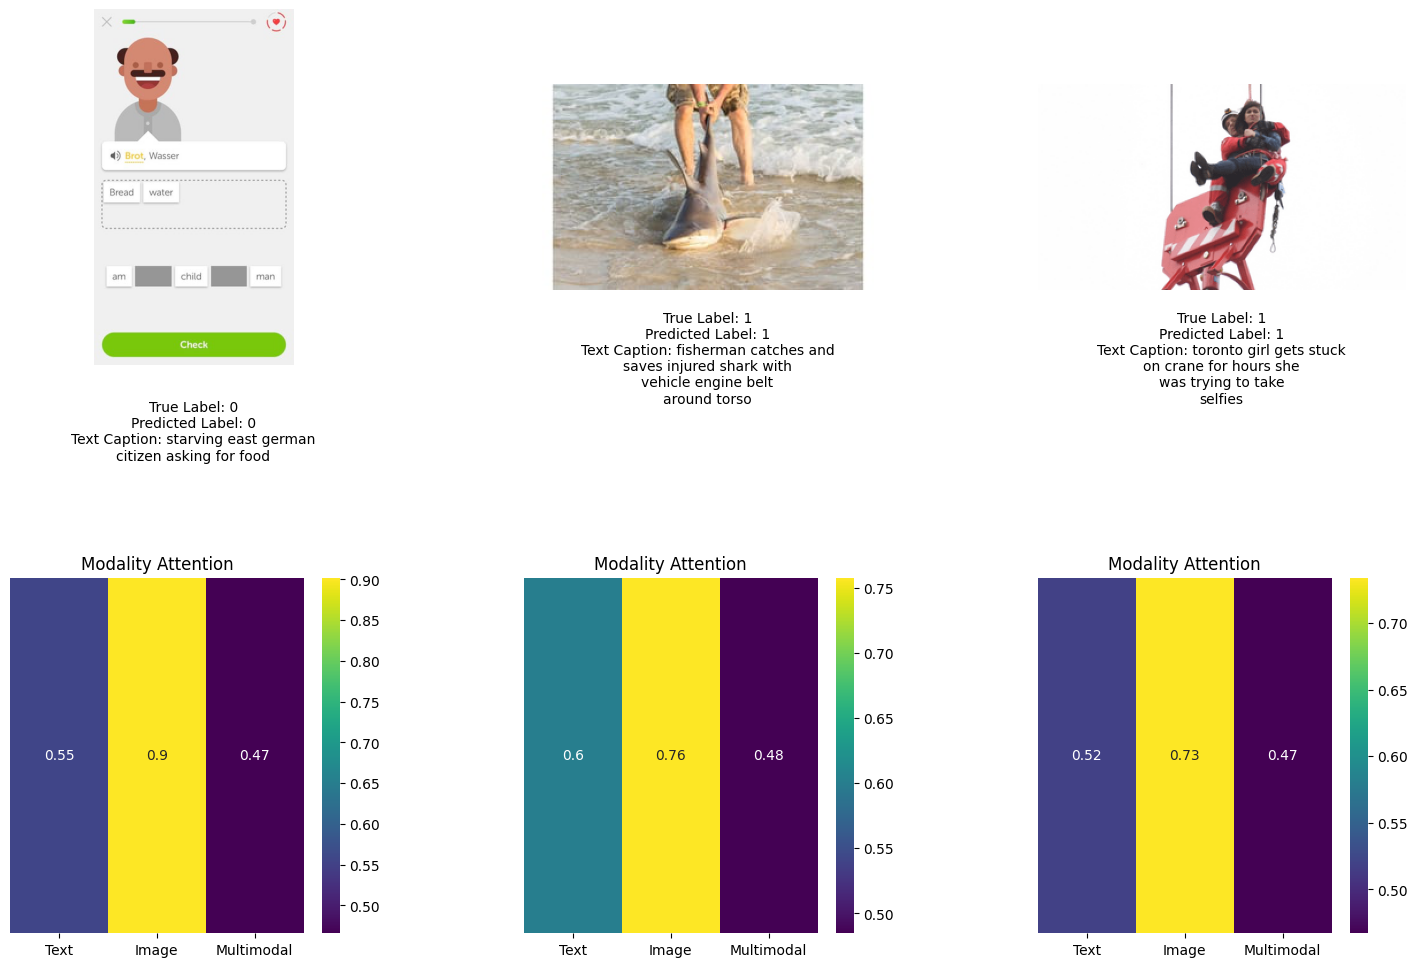

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Load attention arrays
text_attention_array = np.load("../../../output/text_attention.npy")
image_attention_array = np.load("../../../output/image_attention.npy")
multimodal_attention_array = np.load("../../../output/multimodal_attention.npy")
predicted_labels = np.load("../../../output/test_predicted_labels.npy")
ground_truth_labels = np.load("../../../output/test_ground_truth_labels.npy")

attention_matrix = np.stack([text_attention_array, image_attention_array, multimodal_attention_array], axis=1)

# We will analyze indices where we predict correctly and where image is the dominant predictor
correct_indices = np.where(
    (predicted_labels == ground_truth_labels) &
    (image_attention_array > 1.2 * text_attention_array) & 
    (image_attention_array > 1.2 * multimodal_attention_array))[0]

# Pick 5 random samples
np.random.seed(600)
random_indices = np.random.choice(correct_indices, size=4, replace=False)

# Present the best ones
random_indices = [random_indices[0], random_indices[1], random_indices[2]]


# Plot each sample with its image, caption, and attention heatmap
fig, axes = plt.subplots(2, len(random_indices), figsize=(6*len(random_indices), 12),
                         gridspec_kw={'hspace': 0.6, 'wspace': 0.4})

for i, idx in enumerate(random_indices):
    row = TEST_DATA.iloc[idx]

    # Fetch text
    text = row['clean_title']

    # Get image number
    image_num = row['image_num']

    # Fetch Image
    img_path = f"../../../test_images/{image_num}.jpg"
    image = Image.open(img_path).convert('RGB')

    # Fetch Label 
    label = row['2_way_label']
    predicted_label = predicted_labels[idx]
    print(f"Label = {label}, Ground Truth = {ground_truth_labels[idx]}, Predicted Label = {predicted_labels[idx]}")
    wrapped_text = "\n".join(textwrap.wrap(text, width=25))
    
    # Plot image
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].text(
        0.5, -0.1, f"True Label: {label}\nPredicted Label: {predicted_label}\nText Caption: {wrapped_text}", 
        ha='center', va='top', transform=axes[0, i].transAxes, fontsize=10
    )
    
    # Plot modality attention as heatmap
    sns.heatmap(attention_matrix[idx][None, :], cmap="viridis", annot=True,
                xticklabels=['Text', 'Image', 'Multimodal'], yticklabels=False, ax=axes[1, i])
    
    axes[1, i].set_title("Modality Attention")

plt.tight_layout()
plt.show()

### Case 3: Multimodal Features are Needed

Label = 0, Ground Truth = 0, Predicted Label = 0
Label = 0, Ground Truth = 0, Predicted Label = 0
Label = 0, Ground Truth = 0, Predicted Label = 0


/var/folders/qj/tspvs3x90hg30hgcctblgwfh0000gn/T/ipykernel_9292/1108471855.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


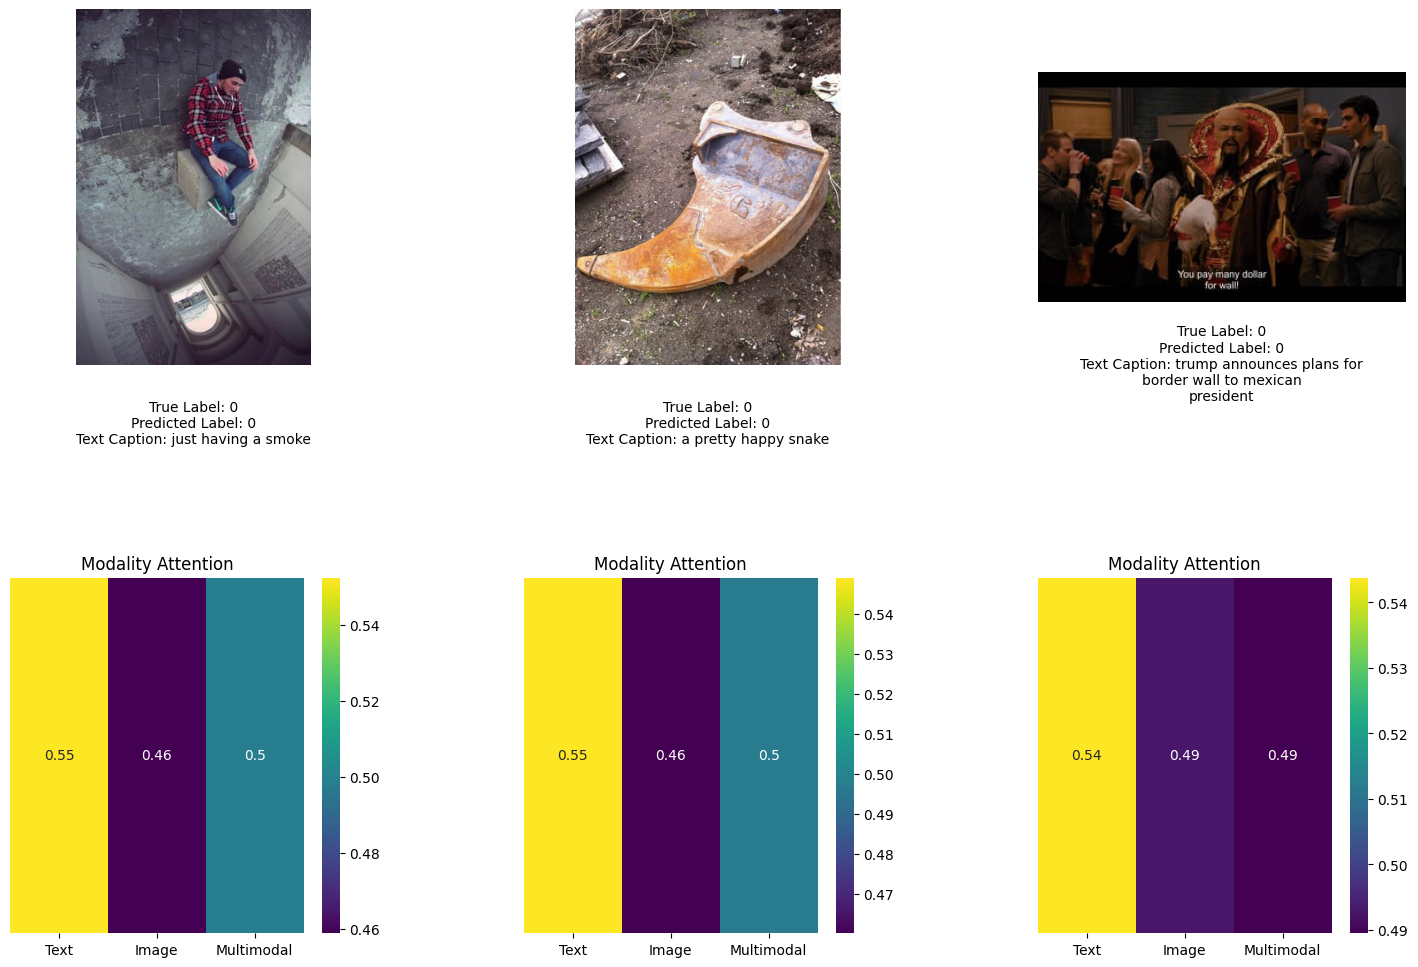

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Load attention arrays
text_attention_array = np.load("../../../output/text_attention.npy")
image_attention_array = np.load("../../../output/image_attention.npy")
multimodal_attention_array = np.load("../../../output/multimodal_attention.npy")
predicted_labels = np.load("../../../output/test_predicted_labels.npy")
ground_truth_labels = np.load("../../../output/test_ground_truth_labels.npy")

attention_matrix = np.stack([text_attention_array, image_attention_array, multimodal_attention_array], axis=1)

# We will analyze indices where we predict correctly and where image is the dominant predictor
correct_indices = np.where(
    (predicted_labels == ground_truth_labels) &
    (multimodal_attention_array > 0.9 * text_attention_array) & 
    (multimodal_attention_array > 0.9 * image_attention_array))[0]

# Pick 5 random samples
np.random.seed(600)
random_indices = np.random.choice(correct_indices, size=4, replace=False)

# Present the best ones
random_indices = [random_indices[0], random_indices[2], random_indices[-1]]


# Plot each sample with its image, caption, and attention heatmap
fig, axes = plt.subplots(2, len(random_indices), figsize=(6*len(random_indices), 12),
                         gridspec_kw={'hspace': 0.6, 'wspace': 0.4})

for i, idx in enumerate(random_indices):
    row = TEST_DATA.iloc[idx]

    # Fetch text
    text = row['clean_title']

    # Get image number
    image_num = row['image_num']

    # Fetch Image
    img_path = f"../../../test_images/{image_num}.jpg"
    image = Image.open(img_path).convert('RGB')

    # Fetch Label 
    label = row['2_way_label']
    predicted_label = predicted_labels[idx]
    print(f"Label = {label}, Ground Truth = {ground_truth_labels[idx]}, Predicted Label = {predicted_labels[idx]}")
    wrapped_text = "\n".join(textwrap.wrap(text, width=25))
    
    # Plot image
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].text(
        0.5, -0.1, f"True Label: {label}\nPredicted Label: {predicted_label}\nText Caption: {wrapped_text}", 
        ha='center', va='top', transform=axes[0, i].transAxes, fontsize=10
    )
    
    # Plot modality attention as heatmap
    sns.heatmap(attention_matrix[idx][None, :], cmap="viridis", annot=True,
                xticklabels=['Text', 'Image', 'Multimodal'], yticklabels=False, ax=axes[1, i])
    
    axes[1, i].set_title("Modality Attention")

plt.tight_layout()
plt.show()